In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import Lmer
import xarray as xr
import re
from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_t1.nc", DATA_PATH / "prp/stage_data_250hz_t2.nc"]
peaks_paths = [Path("files/t1_peaks.csv"), Path("files/t2_peaks.csv")]
labels = labels_t1[1:] + labels_t2[1:]
legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]

def str_to_float_list(s):
    s_clean = s.strip("[]").replace("\n", " ")
    nums = s_clean.split()
    return [float(num) for num in nums]

def str_to_ndarray(s, num_cols=13):
    s_clean = re.sub(r'[\[\]\n]', ' ', s)
    s_clean = re.sub(r'\s+', ' ', s_clean).strip()
    flat = np.fromstring(s_clean, sep=' ')
    return flat.reshape(-1, num_cols)

info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"

epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info
set_global_seed(42)
# TODO: This messes up re-creation of corr data
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading /workspace/data_local/prp/epoched/VP1-t1-epo.fif ...


    Found the data of interest:
        t =    -250.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
844 matching events found
No baseline correction applied
0 projection items activated


### Create correlation data

In [ ]:
# Take peaks.csv and dataset
# For each trial, get the peak time, and calculate correlation of RAW EEG with all other time points to get dist of corrs
# NOTE that for long cond only take trials from val participants
data = xr.load_dataset(data_paths[0])
data

In [2]:
t1_data = xr.load_dataset(data_paths[0])
t2_data = xr.load_dataset(data_paths[1])
t1_peaks = pd.read_csv(peaks_paths[0])
t2_peaks = pd.read_csv(peaks_paths[1])

In [ ]:
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib


def process_row(data, row, labels):
    pred_cols = [f"{label}_pred" for label in labels]
    true_cols = [f"{label}_true" for label in labels]
    offset_before = data.offset_before

    trial_data = data.sel(participant=row["participant"])
    trial_data = trial_data.where(trial_data["trial_index"] == row["epoch"], drop=True)
    trial_eeg = trial_data.data.squeeze("epochs")

    pred_values = (row[pred_cols].values + offset_before).astype(int)
    true_values = (row[true_cols].values + offset_before).astype(int)
    result = {
        "participant": row["participant"],
        "epoch": row["epoch"],
        "condition": row["condition"],
    }
    for i, label in enumerate(labels):
        result[f"{label}_pred"] = trial_eeg.sel(
            samples=range(pred_values[i] - 6, pred_values[i] + 7)
        ).data
        result[f"{label}_true"] = trial_eeg.sel(
            samples=range(true_values[i] - 6, true_values[i] + 7)
        ).data
    return result


def get_peak_activations_parallel(data, peaks, labels):
    with tqdm_joblib(desc="Extracting peaks", total=len(peaks)):
        results = Parallel(n_jobs=14)(
            delayed(process_row)(data, row, labels) for _, row in peaks.iterrows()
        )
    return results

t1_eeg_peaks = pd.DataFrame(get_peak_activations_parallel(t1_data, t1_peaks, labels_t1[1:]))
t2_eeg_peaks = pd.DataFrame(get_peak_activations_parallel(t2_data, t2_peaks, labels_t2[1:]))
cmb_eeg_peaks = pd.merge(t1_eeg_peaks, t2_eeg_peaks, on=["participant", "epoch", "condition"], how="outer", suffixes=("_t1", "_t2"))
cmb_eeg_peaks.to_csv("files/cmb_eeg_peaks.csv", index=False)

### Analyze

#### Calculate peak topos for each label in each condition

In [5]:
cmb_eeg_peaks = pd.read_csv("files/cmb_eeg_peaks_single.csv")
cmb_eeg_peaks = cmb_eeg_peaks[~((cmb_eeg_peaks["condition"] == "long") & (cmb_eeg_peaks["participant"].isin(splits[0])))]
for col in cmb_eeg_peaks.columns:
    if "_true" in col or "_pred" in col:
        cmb_eeg_peaks[col] = cmb_eeg_peaks[col].apply(lambda x: str_to_float_list(x) if isinstance(x, str) else np.nan)
cmb_eeg_peaks = cmb_eeg_peaks.dropna(subset=[f"{label}_true" for label in labels_t1[1:]] + [f"{label}_pred" for label in labels_t2[1:]])
cmb_eeg_peaks_long = cmb_eeg_peaks[cmb_eeg_peaks["condition"] == "long"]
cmb_eeg_peaks_short = cmb_eeg_peaks[cmb_eeg_peaks["condition"] == "short"]
long_peaks_hmp = {label: np.stack(cmb_eeg_peaks_long[f"{label}_true"].dropna().values) for label in labels}
long_peaks_s4 = {label: np.stack(cmb_eeg_peaks_long[f"{label}_pred"].dropna().values) for label in labels}
short_peaks_hmp = {label: np.stack(cmb_eeg_peaks_short[f"{label}_true"].dropna().values) for label in labels}
short_peaks_s4 = {label: np.stack(cmb_eeg_peaks_short[f"{label}_pred"].dropna().values) for label in labels}

In [7]:
mean_topos = {}
for cond in ["short", "long"]:
    mean_topos[cond] = {}
    mean_topos[cond]['hmp'] = {}
    mean_topos[cond]['s4'] = {}
    for label in labels:
        if cond == "short":
            peaks_hmp = short_peaks_hmp[label]
            peaks_s4 = short_peaks_s4[label]
        else:
            peaks_hmp = long_peaks_hmp[label]
            peaks_s4 = long_peaks_s4[label]
        # Average topo across samples
        mean_topo_hmp = np.mean(peaks_hmp, axis=0)
        mean_topo_s4 = np.mean(peaks_s4, axis=0)
        # mean_topo_z = (mean_topo - np.mean(mean_topo)) / np.std(mean_topo)
        mean_topos[cond]['hmp'][label] = mean_topo_hmp
        mean_topos[cond]['s4'][label] = mean_topo_s4

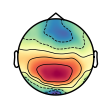

In [8]:
mne.viz.plot_topomap(mean_topos["long"]["hmp"]["t1_3"], positions, show=True, cmap='Spectral_r', sensors=False)
plt.show()

#### Calculate correlations

In [13]:
import warnings
from scipy.stats import norm
warnings.simplefilter("error")
participants = cmb_eeg_peaks["participant"].unique()

# Config
source_cond = "short"
compare_cond = "long"
source_model = "s4"
compare_model = "hmp"
source_col = "true" if source_model == "hmp" else "pred"
compare_col = "true" if compare_model == "hmp" else "pred"

source_rows_per_participant = 10000

# Cosine similarity function
def similarity(a, b):
    # return np.dot(np.mean(a, axis=1), b)
    return np.dot(a, b)
    # dot product van gem. activitit over 13 samples, daar gemiddelde van nemen
    # return np.corrcoef(a, b)[0, 1]
    # return np.abs(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


def precompute_compare_sims(p_compare, labels):
    """Precompute cosine similarities for all compare trials vs their mean topographies."""
    compare_sims = {label: [] for label in labels}
    
    for j, label in enumerate(labels):
        topo = mean_topos[compare_cond][compare_model][label]
        for _, row in p_compare.iterrows():
            val = np.array(row.get(f"{label}_{compare_col}"))
            # val = (val - np.mean(val)) / np.std(val)  # z-score
            sim = similarity(val, topo)
            compare_sims[label].append(sim)

    # Convert to numpy arrays for fast use later
    for label in labels:
        compare_sims[label] = np.array(compare_sims[label])
    
    return compare_sims


def compute_corrs_for_participant(cmb_eeg_peaks, labels):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning, message=".*DataFrame.swapaxes.*")

    p_data = cmb_eeg_peaks
    p_source = p_data[p_data["condition"] == source_cond]
    p_compare = p_data[p_data["condition"] == compare_cond]

    if len(p_source) == 0 or len(p_compare) == 0:
        return None

    p_source = p_source.sample(
        n=min(len(p_source), source_rows_per_participant), random_state=42
    )

    # Precompute all compare cosine similarities
    compare_sims = precompute_compare_sims(p_compare, labels)

    p_corrs = np.full((6, 6, len(p_source), 1), np.nan)

    for source_idx, (_, row_source) in enumerate(p_source.iterrows()):
        for i, label_i in enumerate(labels):
            source_array = np.array(row_source.get(f"{label_i}_{source_col}"))
            # source_array = (source_array - np.mean(source_array)) / np.std(source_array)

            for j, label_j in enumerate(labels):
                sims = compare_sims[label_j]
                compare_topo = mean_topos[compare_cond][compare_model][label_j]
                compare_sim = similarity(source_array, compare_topo)
                # p_corrs[i, j, source_idx, 0] = compare_sim
                # Calculate z-score of similarity between source trial and mean compare topography
                z_sim = (compare_sim - np.mean(sims)) / np.std(sims)
                p_corrs[i, j, source_idx, 0] = z_sim

    return p_corrs

In [14]:
with tqdm_joblib(desc="Participants", total=len(participants)):
    with parallel_backend("loky", n_jobs=12):
        results = Parallel()(
            delayed(compute_corrs_for_participant)(
                cmb_eeg_peaks[cmb_eeg_peaks["participant"] == p], labels
            )
            for p in participants
        )

# Filter out None results and stack
results = [r for r in results if r is not None]
corrs = np.concatenate(results, axis=2)

Participants:   0%|          | 0/21 [00:00<?, ?it/s]

In [76]:
# z-score corrs
corrs = (corrs - np.mean(corrs)) / np.std(corrs)

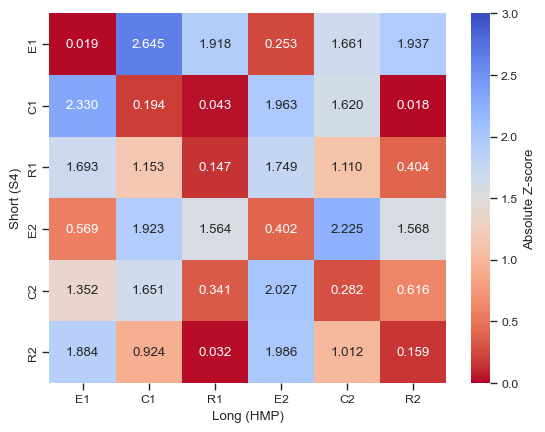

In [15]:
set_seaborn_style()
# from matplotlib.colors import LinearSegmentedColormap
# colors = [(0.2298057 , 0.29871797, 0.75368315), (1, 1, 1), (0.70567316, 0.01555616, 0.15023281), (1, 1, 1), (0.2298057 , 0.29871797, 0.75368315)]  # RGB: white → red → white
# custom_cmap = LinearSegmentedColormap.from_list("white_red_white", colors, N=1024)
# 
sns.heatmap(np.abs(np.nanmean(corrs, axis=(2, 3))), annot=True, fmt=".3f", cmap='coolwarm_r', xticklabels=legible_labels, yticklabels=legible_labels, vmin=0, vmax=3, cbar_kws={'label': 'Absolute Z-score'})
# plt.title("Bootstrapped trial-level correlations between S4 and HMP peaks")
plt.xlabel(f"{compare_cond.capitalize()} ({compare_model.upper()})")
plt.ylabel(f"{source_cond.capitalize()} ({source_model.upper()})")
plt.show()

In [36]:
corrs_trial = np.nanmean(corrs, axis=-1)

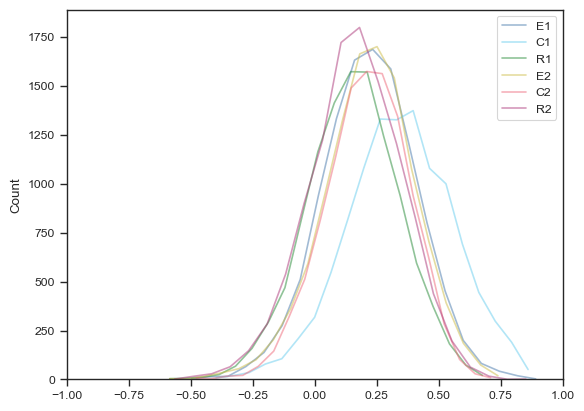

In [154]:
sns.histplot(corrs_trial[0, 0, :], bins=20, element="poly", label="E1", alpha=0.5, fill=False)
sns.histplot(corrs_trial[1, 1, :], bins=20, element="poly", label="C1", alpha=0.5, fill=False)
sns.histplot(corrs_trial[2, 2, :], bins=20, element="poly", label="R1", alpha=0.5, fill=False)
sns.histplot(corrs_trial[3, 3, :], bins=20, element="poly", label="E2", alpha=0.5, fill=False)
sns.histplot(corrs_trial[4, 4, :], bins=20, element="poly", label="C2", alpha=0.5, fill=False)
sns.histplot(corrs_trial[5, 5, :], bins=20, element="poly", label="R2", alpha=0.5, fill=False)

sns.histplot(corrs_trial[0, 1, :], bins=20, element="poly", alpha=0.5, label="E1-C1", fill=False)
sns.histplot(corrs_trial[1, 0, :], bins=20, element="poly", alpha=0.5, label="C1-E1", fill=False)
sns.histplot(corrs_trial[0, 2, :], bins=20, element="poly", alpha=0.5, label="E1-R1", fill=False)
sns.histplot(corrs_trial[1, 2, :], bins=20, element="poly", alpha=0.5, label="C1-R1", fill=False)
plt.legend()
# sns.histplot(corrs_trial[1, 2, :], bins=20)
# sns.histplot(corrs_trial[0, 2, :], bins=20)

plt.xlim(-1, 1)
plt.show()

In [ ]:
for key, value in long_peaks.items():
    print(f"{key}: {value.shape}")
    mean_eeg = np.mean(value, axis=0)
    mne.viz.plot_topomap(mean_eeg, positions, show=True, cmap='Spectral_r', sensors=False)


In [ ]:
for key, value in short_peaks.items():
    print(f"{key}: {value.shape}")
    mean_eeg = np.mean(value, axis=0)
    mne.viz.plot_topomap(mean_eeg, positions, show=True, cmap='Spectral_r', sensors=False)


### Analyze (alternative method, participant/channel difference wise)

In [ ]:
cmb_eeg_peaks = pd.read_csv("files/cmb_eeg_peaks_single.csv")
peaks = {}
for col in cmb_eeg_peaks.columns:
    if "_true" in col or "_pred" in col:
        cmb_eeg_peaks[col] = cmb_eeg_peaks[col].apply(lambda x: str_to_float_list(x) if isinstance(x, str) else np.nan)
cmb_eeg_peaks = cmb_eeg_peaks.dropna(subset=[f"{label}_true" for label in labels_t1[1:]] + [f"{label}_pred" for label in labels_t2[1:]])
for participant in cmb_eeg_peaks["participant"].unique():
    par_cond_peaks = cmb_eeg_peaks[(cmb_eeg_peaks["participant"] == participant)]
    par_cond_peaks_long = par_cond_peaks[par_cond_peaks["condition"] == "long"]
    par_cond_peaks_short = par_cond_peaks[par_cond_peaks["condition"] == "short"]
    long_hmp_peaks = {label: np.mean(np.stack(par_cond_peaks_long[f"{label}_true"].dropna().values), axis=0) for label in labels}
    short_hmp_peaks = {label: np.mean(np.stack(par_cond_peaks_short[f"{label}_true"].dropna().values), axis=0) for label in labels}
    long_s4_peaks = {label: np.mean(np.stack(par_cond_peaks_long[f"{label}_pred"].dropna().values), axis=0) for label in labels}
    short_s4_peaks = {label: np.mean(np.stack(par_cond_peaks_short[f"{label}_pred"].dropna().values), axis=0) for label in labels}
    peaks[participant] = {
        "long": {"hmp": long_hmp_peaks, "s4": long_s4_peaks},
        "short": {"hmp": short_hmp_peaks, "s4": short_s4_peaks}
    }

In [ ]:
source_cond = "short"
compare_cond = "long"
source_model = "s4"
compare_model = "hmp"
participants = cmb_eeg_peaks["participant"].unique()
n = 10000
diffs = np.full((len(labels), len(labels), len(participants), n, 64), np.nan)

for i, label_i in enumerate(labels):
    for j, label_j in enumerate(labels):
        for k, participant in enumerate(participants):
            # For every label_src, label_cmp, participant combination,
            # Compare participant + label_src to bootstrapped other participants label_cmp
            source_peak = peaks[participant][source_cond][source_model][label_i]
            other_participants = [p for p in participants if p != participant]
            bootstrapped_participants = np.random.choice(other_participants, size=n, replace=True)
            bootstrapped_peaks = np.array([peaks[p][compare_cond][compare_model][label_j] for p in bootstrapped_participants])
            diffs[i, j, k, :, :] = source_peak - bootstrapped_peaks

In [ ]:
# diffs: shape (label_i, label_j, participant, n, channel)
mean_diffs = np.nanmean(diffs, axis=2)  # shape: (label_i, label_j, n, channel)

sig_diff_matrix = np.zeros((len(labels), len(labels), 64), dtype=bool)

for i in range(len(labels)):
    for j in range(len(labels)):
        for ch in range(64):
            boot_diffs = mean_diffs[i, j, :, ch]
            if np.isnan(boot_diffs).all():
                continue
            lower = np.nanpercentile(boot_diffs, 2.5)
            upper = np.nanpercentile(boot_diffs, 97.5)
            sig_diff_matrix[i, j, ch] = (lower > 0 or upper < 0)
sig_channel_counts = sig_diff_matrix.sum(axis=2)

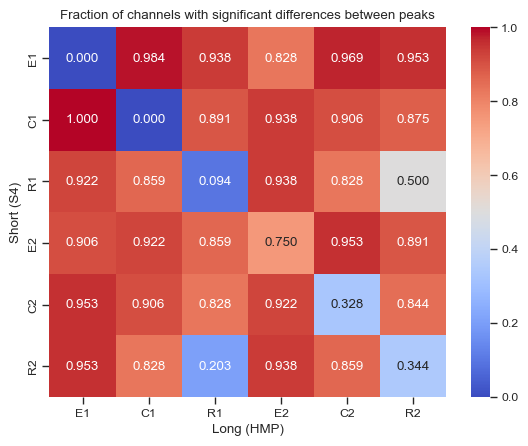

In [ ]:
set_seaborn_style()
sns.heatmap(sig_channel_counts / 64, annot=True, fmt=".3f", cmap="coolwarm", xticklabels=legible_labels, yticklabels=legible_labels)
plt.title("Fraction of channels with significant differences between peaks")
plt.xlabel(f"{compare_cond.capitalize()} ({compare_model.upper()})")
plt.ylabel(f"{source_cond.capitalize()} ({source_model.upper()})")
plt.show()

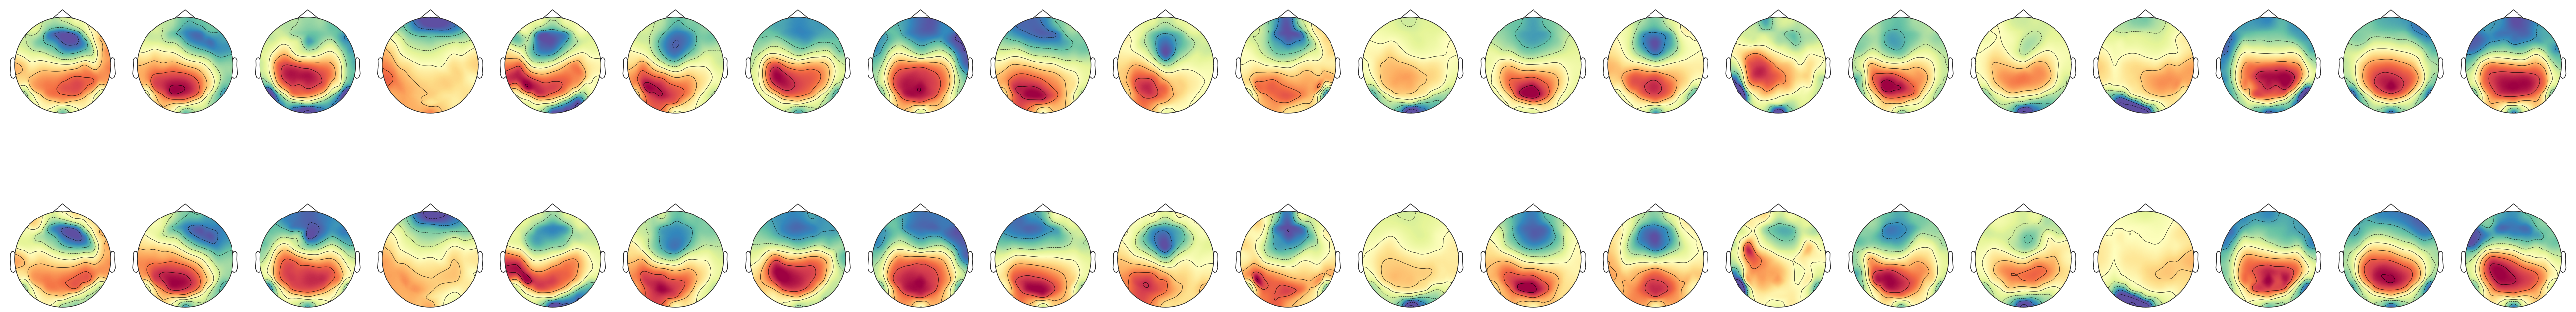

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=len(participants), figsize=(2.5 * len(participants), 10))
for i, (participant, data) in enumerate(peaks.items()):
    mne.viz.plot_topomap(data["long"]["hmp"]["t1_3"], positions, axes=axs[0, i], sensors=False, cmap='Spectral_r', show=False)
    mne.viz.plot_topomap(data["short"]["s4"]["t1_3"], positions, axes=axs[1, i], sensors=False, cmap='Spectral_r', show=False)

plt.tight_layout()
plt.show()

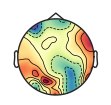

In [ ]:
mne.viz.plot_topomap(peaks["VP8"]["long"]["hmp"]["t2_1"] - peaks["VP1"]["long"]["s4"]["t2_1"], positions, show=True, cmap='Spectral_r', sensors=False)
plt.show()